# Find S

In [11]:
import numpy as np
import pandas as pd

# read dataset
df = pd.read_csv('datasets/mlLab/140524_1.csv')
dt = np.array(df)
dtPos = np.array([i[:-1] for i in dt if i[-1]=='yes'])

# implement find s algorithm
h = dtPos[0]
for x in dtPos[1:]:
    for f in range(len(x)):
        if h[f]!='?' and h[f]!=x[f]: h[f]='?'
print(f"Absolute hypothesis : {h}")

Absolute hypothesis : ['sunny' 'warm' '?' 'strong' '?' '?']


# Candidate Elimination

In [12]:
import numpy as np
import pandas as pd

# read dataset
df = pd.read_csv('datasets/mlLab/140524_1.csv')
dt = np.array(df)

# initialise g and s
fCount = dt.shape[1]-1
g = [['?']*fCount]*fCount
for x in dt:
    if x[-1]=='yes':
        s=x[:-1]

# implement candidate elimination algorithm
for x in dt:
    if x[-1]=='yes':
        for f in range(fCount):
            if x[f]!=s[f]:
                s[f]='?'
                g[f][f]='?'
    else:
        for f in range(fCount):
            if x[f]!=s[f]:g[f][f]=s[f]
            else: g[f][f]='?'
G = np.unique(g,axis=0)
print(f"G : {G}\nS : {s}")

G : [['sunny' 'warm' '?' '?' '?' '?']]
S : ['sunny' 'warm' '?' 'strong' '?' '?']


# Decision Tree : ID3

In [13]:
import numpy as np
import pandas as pd

class Node:
    def __init__(self,attribute):
        self.attribute = attribute
        self.children = []
        self.answer = None

def subtables(data: np.ndarray, col: int, delete:bool = False):
    dict = {}
    items = np.unique(data[:,col])

    for item in items:
        dict[item] = data[data[:,col]==item]
        if delete: dict[item] = np.delete(dict[item],col,axis=1)
        
    return items, dict

def entropy(S: np.ndarray) -> float:
    _, counts = np.unique(S,return_counts=True)
    ps = counts/len(S)
    return -np.sum(ps*np.log2(ps))

def gain_ratio(data: np.ndarray, col:int) -> float:
    eTotal = entropy(data[:,-1])
    items, dict = subtables(data,col)

    eSubset = 0
    intrensicVal = 0
    totalSize = data.shape[0]

    for item in items:
        subset = dict[item]
        ratio = len(subset)/totalSize
        eSubset += ratio*entropy(subset[:,-1])
        intrensicVal -= ratio*np.log2(ratio)

    if intrensicVal==0: return 0

    infoGain = eTotal - eSubset
    return infoGain

def create_node(data: np.ndarray, metadata: list) -> Node:
    if len(np.unique(data[:,-1])) == 1:
        node = Node(None)
        node.answer = np.unique(data[:,-1])[0]
        return node
    
    gains = [gain_ratio(data, col) for col in range(data.shape[1]-1)]
    split = np.argmax(gains)
    node = Node(metadata[split])
    items, dict  = subtables(data,split,delete=True)

    for item in items:
        child = create_node(dict[item],np.delete(metadata,split))
        node.children.append((item,child))
    return node

def predict(node: Node, instance: list, metadata: list):
    if node.answer is not None:
        return node.answer
    
    value = instance[metadata.index(node.attribute)]

    for item, child in node.children:
        if item == value:
            predict(child, instance, metadata)

def empty(size: int):
    return '\t'*size

def print_tree(node: Node, level: int=0):
    if node.answer is not None:
        print(empty(level),node.answer)
        return

    print(empty(level),node.attribute)

    for item, n in node.children:
        print(empty(level+1),item)
        print_tree(n,level+2)

def print_prediction(node: Node, testdata: np.ndarray, metadata: list):
    for instance in testdata:
        prediction = predict(node, instance, metadata)
        print(f"Test Instance : {instance}\nPrediction : {prediction}")

dTrain = pd.read_csv('datasets/mlLab/290524.csv')
dTest = pd.read_csv('datasets/mlLab/060624.csv')
metadata = list(dTrain)[:-1]
dTrain = np.array(dTrain)
dTest = np.array(dTest)

node = create_node(dTrain,metadata)

print("Decision Tree : \n")
print_tree(node)
print("Predictions : \n")
print_prediction(node, dTest, metadata)

Decision Tree : 

 weather
	 cloudy
		 yes
	 rain
		 wind
			 strong
				 no
			 weak
				 yes
	 sunny
		 humidity
			 high
				 no
			 normal
				 yes
Predictions : 

Test Instance : ['sunny' 'hot' 'high' 'weak']
Prediction : None
Test Instance : ['sunny' 'hot' 'high' 'strong']
Prediction : None
Test Instance : ['cloudy' 'hot' 'high' 'weak']
Prediction : None


# ANN

In [14]:
import numpy as np

X = np.array([[2,9],[1,5],[3,6]],dtype=float)
y = np.array([[92],[86],[89]],dtype=float)

X = X/np.max(X,axis=0)
y = y/100

epochs = 5000
lr =0.01
l0 = 2
l1 = 3
l2 = 1

wh = np.random.uniform(size=(l0,l1))
bh = np.random.uniform(size=(1,l1))
wout = np.random.uniform(size=(l1,l2))
bout = np.random.uniform(size=(1,l2))

def sig(x):
    return 1/(1+np.exp(-x))

def dSig(x):
    return x*(1-x)

for _ in range(epochs):
    hOut = sig(X.dot(wh)+bh)
    oOut = sig(hOut.dot(wout)+bout)

    dOut = (y-oOut)*dSig(oOut)
    dHid = dOut.dot(wout.T) * dSig(hOut)

    wout += hOut.T.dot(dOut) * lr
    wh += X.T.dot(dHid) * lr

print(oOut)

[[0.8927786 ]
 [0.8755129 ]
 [0.88939491]]


# Naive Bayes Classifier

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def classify(dtrain, dtest):
    nTotal = dtrain.shape[0]
    nYes = nNo = 0
    for i in dTrain:
        if i[-1] == 'yes': nYes+=1
        else: nNo +=1
    pYes = nYes/nTotal
    pNo = nNo/nTotal

    pdNeg = pdPos = np.zeros(dtest.shape[1]-1)
    acc = 0

    print("Instance\tPrediction\tTarget")
    for te in range(dtest.shape[0]):
        for f in range(dtest.shape[1]-1):
            cNo = cYes = 0
            for tr in range(dtrain.shape[1]-1):
                if dtest[te,f] == dtrain[tr,f]:
                    if dtrain[tr,-1] == 'yes': cYes +=1
                    else : cNo+=1
            pdPos[f] = cYes/nYes
            pdNeg[f] = cNo/nNo

        pPos = pYes
        pNeg = pNo
        for i in range(dtest.shape[1]-1):
            pPos *= pdPos[i]
            pNo *= pdNeg[i]

        prediction = 'yes' if pPos>pNeg else 'no'
        if prediction==dtest[te,-1]: acc+=1

        print(f"{te+1}\t\t{prediction}\t\t{dtest[te,-1]}")
    acc /= dtest.shape[0]
    print(f"Accuracy : {acc}")

df = pd.read_csv('datasets/mlLab/290524.csv')
dtrain, dtest = train_test_split(np.array(df), test_size=0.3)
classify(dtrain, dtest)

Instance	Prediction	Target
1		no		yes
2		no		yes
3		yes		no
4		no		no
5		yes		yes
Accuracy : 0.4


# Bayesian Belief Network

In [16]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

df = pd.read_csv('datasets/mlLab/heart.csv')
model = BayesianNetwork([('age','heartdisease'),('sex','heartdisease'),('exang','heartdisease'),('cp','heartdisease'),('heartdisease','restecg'),('heartdisease','chol')])
model.fit(df,estimator=MaximumLikelihoodEstimator)

dfInfer = VariableElimination(model)
q0 = dfInfer.query(variables=['heartdisease'],evidence={'restecg':1})
q1 = dfInfer.query(variables=['heartdisease'],evidence={'cp':1})

print(f"Probability of heartdisease given evidence = restecg :\n{q0}\n")
print(f"Probability of heartdisease given evidence = cp : \n{q1}")

Probability of heartdisease given evidence = restecg :
+-----------------+---------------------+
| heartdisease    |   phi(heartdisease) |
+=================+=====================+
| heartdisease(0) |              0.1016 |
+-----------------+---------------------+
| heartdisease(1) |              0.0000 |
+-----------------+---------------------+
| heartdisease(2) |              0.2361 |
+-----------------+---------------------+
| heartdisease(3) |              0.2017 |
+-----------------+---------------------+
| heartdisease(4) |              0.4605 |
+-----------------+---------------------+

Probability of heartdisease given evidence = cp : 
+-----------------+---------------------+
| heartdisease    |   phi(heartdisease) |
+=================+=====================+
| heartdisease(0) |              0.2992 |
+-----------------+---------------------+
| heartdisease(1) |              0.2018 |
+-----------------+---------------------+
| heartdisease(2) |              0.1739 |
+----------

# K Means Clustering

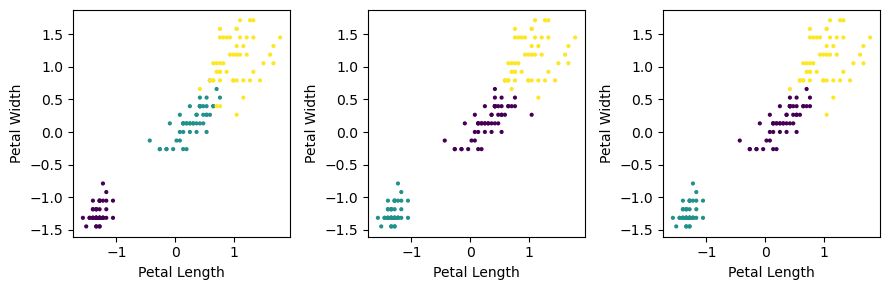

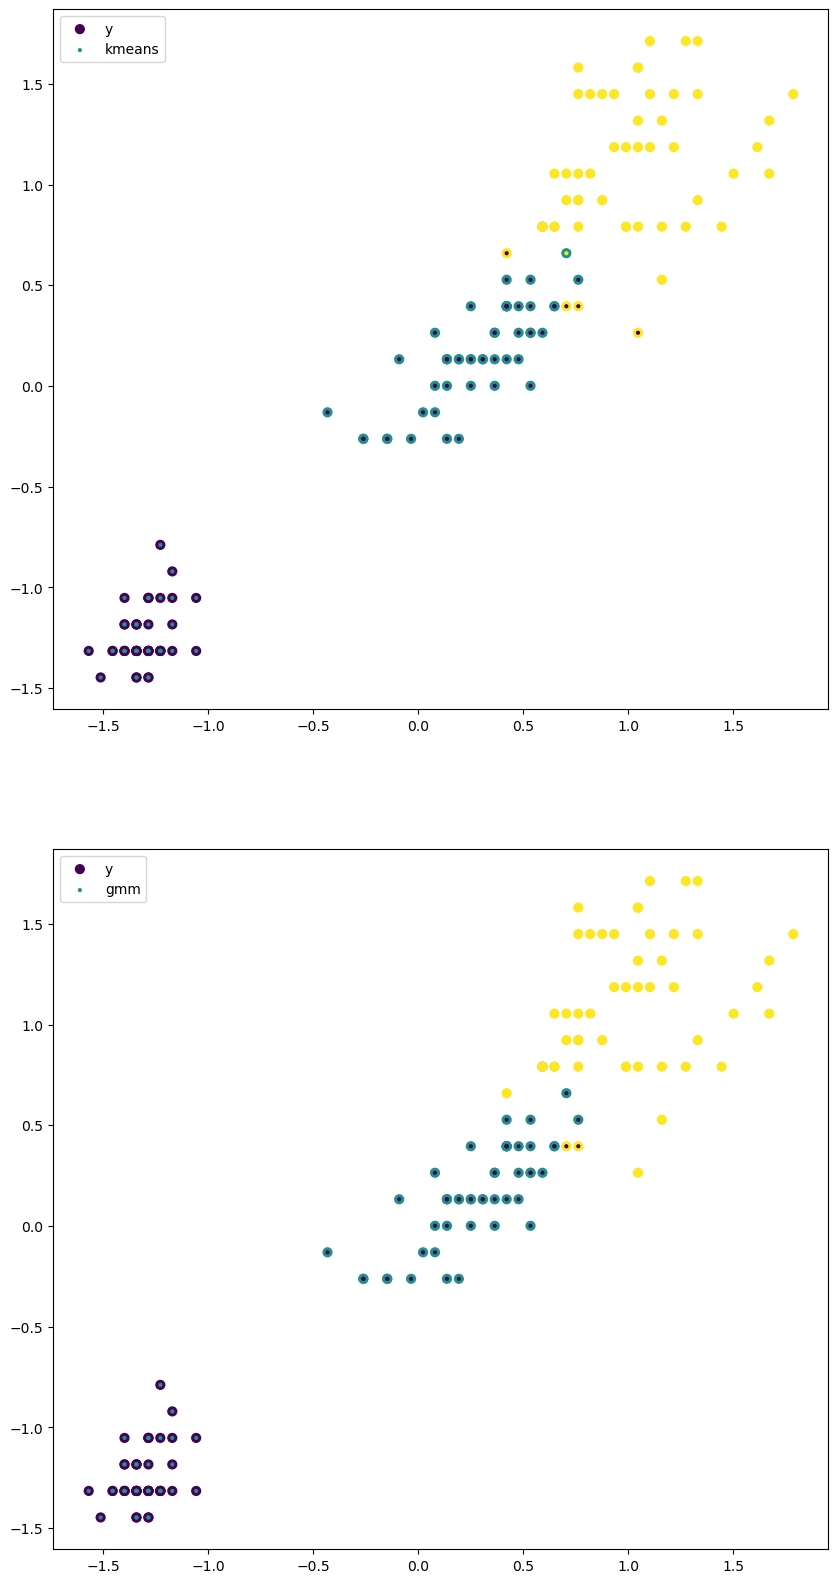

In [17]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

X = load_iris().data[:,2:]
y = load_iris().target

X = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

gmix = GaussianMixture(n_components=3)
gmix.fit(X)

plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.scatter(X[:,0],X[:,1],c=y,cmap='viridis',s=4)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.subplot(1,3,2)
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_,cmap='viridis',s=4)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.subplot(1,3,3)
plt.scatter(X[:,0],X[:,1],c=gmix.predict(X),cmap='viridis',s=4)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.tight_layout()

plt.figure(figsize=(10,20))
plt.subplot(2,1,1)
plt.scatter(X[:,0],X[:,1],c=y,cmap='viridis',s=40)
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_,cmap='viridis',s=4)
plt.legend(['y','kmeans'],loc=2)
plt.subplot(2,1,2)
plt.scatter(X[:,0],X[:,1],c=y,cmap='viridis',s=40)
plt.scatter(X[:,0],X[:,1],c=gmix.predict(X),cmap='viridis',s=4)
plt.legend(['y','gmm'],loc=2)
plt.show()

# KNN

In [18]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

X = load_iris().data
y = load_iris().target

xtr, xte, ytr, yte = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=42)

model = KNeighborsClassifier(n_neighbors=3)
model.fit(xtr,ytr)

ypred = model.predict(xte)

print(classification_report(y_true=yte,y_pred=ypred))
print(confusion_matrix(y_true=yte,y_pred=ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


# Locally Weighted Regression

/var/folders/tx/44n992cx27q28v08nqkpwfqh0000gn/T/ipykernel_62009/369753231.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[j,j] = np.exp(diff*diff.T/(-2.0*k**2))
/var/folders/tx/44n992cx27q28v08nqkpwfqh0000gn/T/ipykernel_62009/369753231.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ypred[i] = xmat[i] * localWeight(xmat[i],xmat,ymat,k)


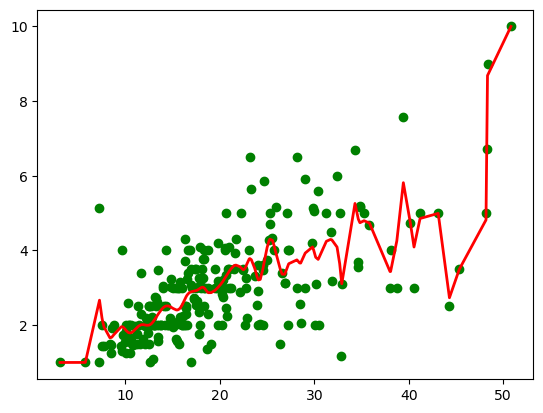

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def kernel(point, xmat, k):
    m = xmat.shape[0]
    weights = np.mat(np.eye(m))

    for j in range(m):
        diff = point - xmat[j]
        weights[j,j] = np.exp(diff*diff.T/(-2.0*k**2))
    return weights

def localWeight(point, xmat, ymat, k):
    wei = kernel(point, xmat, k)
    W = (xmat.T*(wei*xmat)).I*(xmat.T*(wei*ymat.T))
    return W

def locallyWeightedRegression(xmat, ymat, k):
    m = xmat.shape[0]
    ypred = np.zeros(m)

    for i in range(m):
        ypred[i] = xmat[i] * localWeight(xmat[i],xmat,ymat,k)
    
    return ypred

df = pd.read_csv('datasets/mlLab/bill.csv')
bill = np.array(df.total_bill)
tip = np.array(df.tip)

mbill = np.mat(bill)
mtip = np.mat(tip)

m = mbill.shape[1]
ones = np.mat(np.ones(m))

X = np.hstack((ones.T,mbill.T))
ypred = locallyWeightedRegression(X,mtip,0.5)
sortIndex = X[:,1].argsort(0)
xsort = X[sortIndex][:,0]

plt.scatter(bill,tip,color='green')
plt.plot(xsort[:,1],ypred[sortIndex],color='red',linewidth=2)
plt.show()

# SVM

In [20]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

df = pd.read_csv('datasets/mlLab/social.csv')
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

df = np.array(df)
X = df[:,:-1]
y = df[:,-1]
X = StandardScaler().fit_transform(X)

xtr, xte, ytr, yte = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)
model = SVC().fit(xtr,ytr)
ypred = model.predict(xte)

print(confusion_matrix(yte,ypred))

[[48  4]
 [ 2 26]]
